In [12]:
import matplotlib.pyplot as plt
import numpy as np
from random import random, shuffle

from scipy.integrate import simps
import pandas as pd
import sys
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import seaborn as sns

sys.path.append("..")
from utils.load_las_data import normalize_z_with_minz_in_a_radius

from config import args
from utils.load_las_data import *
from utils.useful_functions import *
import os
import numpy as np; np. set_printoptions(suppress=True);  # display values without scientific notation
import pandas as pd
from laspy.file import File
from sklearn.neighbors import NearestNeighbors
import warnings
import random

In [13]:
def load_and_clean_single_las(las_filename):
    """Load a LAD file into a np.array, convert coordinates to meters, clean a few anomalies in plots."""
    # Parse LAS files
    las = File(las_filename, mode="r")
    x_las = las.X / 100  # we divide by 100 as all the values in las are in cm
    y_las = las.Y / 100
    z_las = las.Z / 100
    r = las.Red
    g = las.Green
    b = las.Blue
    nir = las.nir
    intensity = las.intensity
    return_num = las.return_num
    num_returns = las.num_returns
    points_nparray = np.asarray(
        [x_las, y_las, z_las, r, g, b, nir, intensity, return_num, num_returns]
    ).T

    # There is a file with 2 points 60m above others (maybe birds), we delete these points
    if las_filename.endswith("Releve_Lidar_F70.las"):
        points_nparray = points_nparray[points_nparray[:, 2] < 640]
    # We do the same for the intensity
    if las_filename.endswith("POINT_OBS8.las"):
        points_nparray = points_nparray[points_nparray[:, -2] < 32768]
    if las_filename.endswith("Releve_Lidar_F39.las"):
        points_nparray = points_nparray[points_nparray[:, -2] < 20000]

    # get the center of a rectangle bounding the points
    xy_centers = [
        (x_las.max() - x_las.min()) / 2.0,
        (y_las.max() - y_las.min()) / 2.0,
    ]
    return points_nparray, xy_centers


def load_my_norm_data(args):

    # We open las files and create a training dataset
    nparray_clouds_dict = {}  # dict to store numpy array with each plot separately
    xy_centers_dict = (
        {}
    )  # we keep track of plots means to reverse the normalisation in the future

    # We iterate through las files and transform them to np array
    las_filenames = get_files_of_type_in_folder(args.las_placettes_folder_path, ".las")

    all_points_nparray = np.empty((0, len(args.input_feats) - 1))
    for las_filename in las_filenames:
        # Parse LAS files
        points_nparray, xy_centers = load_and_clean_single_las(las_filename)
        points_nparray = normalize_z_with_smooth_spline(
            points_nparray, xy_centers, args
        )
        #         points_nparray = transform_features_of_plot_cloud(
        #             points_nparray, args
        #         )
        all_points_nparray = np.append(all_points_nparray, points_nparray, axis=0)
        plot_name = get_filename_no_extension(las_filename)
        nparray_clouds_dict[plot_name] = points_nparray
        xy_centers_dict[plot_name] = xy_centers

    return all_points_nparray, nparray_clouds_dict, xy_centers_dict


def select_my_clouds():
    # F49 = nparray_clouds_dict["Releve_Lidar_F49"][:,:3]
    # F68 = nparray_clouds_dict["Releve_Lidar_F68"][:,:3]  # Vm everywhere
    # OBS_2021_6 = nparray_clouds_dict["2021_POINT_OBS6"][:,:3]  # "hyper flag en termes de MNT"
    # F20 = nparray_clouds_dict["Releve_Lidar_F20"][:,:3]  # "hyper flag en termes de MNT"

    plots_of_interest = [
        "Releve_Lidar_F69",
        "2021_POINT_OBS9",  # grass 100%, high slope: 0-3m to 0-0.4cm slope with 1.5
        "Releve_Lidar_F49",  # loads of high vegetation. Ok with 1.5m
        "Releve_Lidar_F68",  # dense bushes. Ok with 1.5 : adds contrast.
        "2021_POINT_OBS6",  # 75% grass (subestimation of model). might add contrats linked to grass
        "Releve_Lidar_F20",  # 75% grass, 25% mid veg. ok,
        "2021_POINT_OBS59",
    ]
    # focus on medium veg
    plots_of_interest = plots_of_interest + []
    selection = {
        key: value
        for key, value in nparray_clouds_dict.items()
        if key in plots_of_interest
    }
    return selection

In [3]:
all_points_nparray, nparray_clouds_dict, xy_centers_dict = load_my_norm_data(args)
selection = select_my_clouds()

<Figure size 432x288 with 0 Axes>

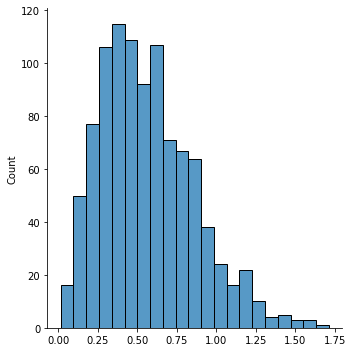

In [25]:
sigma, clip = 0.01, 0.03
plt.figure()
v1 = np.clip(
    sigma * np.random.randn(2,1000),
    a_min=-clip,
    a_max=clip,
).astype(np.float32) * 25
v2 = np.clip(
    sigma * np.random.randn(2,1000),
    a_min=-clip,
    a_max=clip,
).astype(np.float32) * 25
sns.displot(np.sqrt((v1-v2)*(v1-v2)).sum(axis=0))
plt.show()

In [21]:
np.random.randn(2,10000).shape

(2, 10000)

In [4]:
from utils.load_las_data import normalize_z_with_smooth_spline
from em_gamma.get_gamma_parameters_em import get_gamma_parameters
# Fit a mixture of 2 gamma distribution if not already done
all_z = all_points_nparray[:, 2]
params = get_gamma_parameters(all_z, args)

Likelihood at init: 0.576
    NR it 0 - obj = 1.394 -0.451
    NR it 1 - obj = 0.548 0.309
    NR it 2 - obj = 0.151 0.052
    NR it 3 - obj = 0.018 0.002
    NR it 4 - obj = 0.000 0.000
Newton Rachson terminated
Likelihood at ite 0: 1.962
    NR it 0 - obj = 2.040 0.056
    NR it 1 - obj = 0.806 0.003
    NR it 2 - obj = 0.226 0.000
    NR it 3 - obj = 0.028 0.000
    NR it 4 - obj = 0.001 0.000
Newton Rachson terminated
Likelihood at ite 1: 1.629
    NR it 0 - obj = 0.511 0.015
    NR it 1 - obj = 0.116 0.000
    NR it 2 - obj = 0.009 0.000
    NR it 3 - obj = 0.000 0.000
Newton Rachson terminated
Likelihood at ite 2: 1.651
    NR it 0 - obj = 0.630 0.025
    NR it 1 - obj = 0.155 0.001
    NR it 2 - obj = 0.014 0.000
    NR it 3 - obj = 0.000 0.000
Newton Rachson terminated
Likelihood at ite 3: 1.606
    NR it 0 - obj = 0.312 0.019
    NR it 1 - obj = 0.050 0.000
    NR it 2 - obj = 0.002 0.000
    NR it 3 - obj = 0.000 0.000
Newton Rachson terminated
Likelihood at ite 4: 1.601


In [5]:
from scipy.stats import gamma

def view_distribution(params, all_z):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    x = np.linspace(0, 10, 100)
    plt.hist(all_z, bins=100, range=(0, 10), density=True)
    plt.plot(
        x, params["phi"] * gamma.pdf(x, params["a_g"], 0, params["scale_g"]), "r-", lw=1, label="gamma1"
    )
    plt.plot(
        x, params["phi_2"] * gamma.pdf(x, params["a_v"], 0, params["scale_v"]), "k-", lw=1, label="gamma2"
    )
    plt.tight_layout()
    axes = plt.gca()
    axes.set_ylim([0, 0.5])
    plt.show(block=True)
view_distribution(params, all_z)

In [6]:
params

{'phi': 0.5083025351931484,
 'a_g': 0.4287375828029705,
 'a_v': 3.9842894945640164,
 'loc_g': 0,
 'loc_v': 0,
 'phi_2': 0.49169746480685156,
 'scale_g': 0.536849407125017,
 'scale_v': 1.3661828203042392}